In [3]:
#creates connectivity matrix

import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image, input_data, datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = ['sub-084']
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

run_num = 3
runs = list(range(1, run_num + 1))

# Define the number of ROIs for the Schaefer atlas
n_rois = 200

def verify_standard_space(img):
    """Verify image is in 2mm standard space"""
    if img.shape[:3] != (91, 109, 91):
        logging.warning(f"Unexpected shape: {img.shape}")
        return False
    
    vox_size = np.sqrt(np.sum(img.affine[:3, :3] ** 2, axis=0))
    if not np.allclose(vox_size, [2., 2., 2.], atol=0.1):
        logging.warning(f"Unexpected voxel size: {vox_size}")
        return False
    
    return True

def create_connectivity_matrix(ss):
    """Create connectivity matrix using standard space data"""
    logging.info(f"Processing subject: {ss}")
    
    # Load Schaefer atlas (already in MNI 2mm space)
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2)
    atlas_img = atlas.maps
    
    all_runs_data = []
    
    for rn in runs:
        # Load standard space data
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/reg_standard/filtered_func_run-0{rn}_standard.nii.gz'
        
        if not os.path.exists(run_path):
            logging.warning(f'Standard space data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        
        # Verify standard space
        if not verify_standard_space(subject_img):
            logging.warning(f"Data not in expected standard space for {ss} run-{rn}")
            continue
        
        # Extract time series using the atlas
        # Updated to use zscore_sample and memory='nilearn_cache', verbose=0
        masker = NiftiLabelsMasker(
            labels_img=atlas_img,
            standardize='zscore_sample',  # Updated standardization strategy
            memory=None,  # Disable memory caching to avoid joblib warnings
            verbose=0
        )
        
        time_series = masker.fit_transform(subject_img)
        all_runs_data.append(time_series)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix with updated standardize parameter
    correlation_measure = ConnectivityMeasure(
        kind='correlation',
        standardize='zscore_sample'  # Updated standardization strategy
    )
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    
    return connectivity_matrix

def main():
    # Create output directory if it doesn't exist
    output_dir = f'{results_dir}/connectivity_matrices_{n_rois}_standard'
    os.makedirs(output_dir, exist_ok=True)
    
    for ss in subs:
        try:
            connectivity_matrix = create_connectivity_matrix(ss)
            if connectivity_matrix is not None:
                # Save matrix
                output_path = f'{output_dir}/{ss}_connectivity_matrix_standard.npy'
                np.save(output_path, connectivity_matrix)
                logging.info(f'Saved standard space connectivity matrix for {ss}')
                
                # Optional: Verify the saved matrix
                loaded_matrix = np.load(output_path)
                if not np.allclose(connectivity_matrix, loaded_matrix):
                    logging.warning(f'Matrix verification failed for {ss}')
                
        except Exception as e:
            logging.error(f'Error processing subject {ss}: {str(e)}')
            continue

if __name__ == "__main__":
    main()

/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
2024-11-20 18:22:17,748 - INFO - Processing subject: sub-025
2024-11-20 18:22:56,502 - INFO - Saved standard space connectivity matrix for sub-025
2024-11-20 18:22:56,505 - INFO - Processing subject: sub-038
2024-11-20 18:23:33,553 - INFO - Saved standard space connectivity matrix for sub-038
2024-11-20 18:23:33,556 - INFO - Processing subject: sub-057
2024-11-20 18:24:10,5

In [2]:
# analyze connectivity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import os

# Create output directory if it doesn't exist
output_dir = 'figures'
os.makedirs(output_dir, exist_ok=True)

# Load subject information
curr_dir = "."  # Adjust if needed
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = ['sub-084']
subs = sub_info[(sub_info['group'] == 'control') & 
                (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Initialize lists to store statistics
all_stats = []

# Process each subject
for sub in subs:
    try:
        # Load the connectivity matrix
        matrix_path = f'{curr_dir}/results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy'
        if not os.path.exists(matrix_path):
            print(f"Matrix file not found for subject {sub}")
            continue
            
        conn_matrix = np.load(matrix_path)
        
        # Check for NaN values
        if np.any(np.isnan(conn_matrix)):
            print(f"Warning: NaN values found in connectivity matrix for subject {sub}")
            continue
            
        # Check if matrix is symmetric
        if not np.allclose(conn_matrix, conn_matrix.T):
            print(f"Warning: Connectivity matrix for subject {sub} is not symmetric")
            
        # Create mask for diagonal
        mask = ~np.eye(conn_matrix.shape[0], dtype=bool)
        
        # Calculate statistics (excluding diagonal)
        stats = {
            'subject': sub,
            'mean_correlation': np.mean(conn_matrix[mask]),
            'std_deviation': np.std(conn_matrix[mask]),
            'min_correlation': np.min(conn_matrix[mask]),
            'max_correlation': np.max(conn_matrix[mask])
        }
        all_stats.append(stats)
        
        # Create visualization
        plt.figure(figsize=(10, 8))
        
        # Create heatmap
        sns.heatmap(conn_matrix, 
                   cmap='RdBu_r',
                   center=0,
                   vmin=-1,
                   vmax=1,
                   square=True,
                   xticklabels=False,
                   yticklabels=False)
        
        # Add title and labels
        plt.title(f'{sub} Connectivity Matrix (Standard Space)', fontsize=14)
        plt.xlabel('ROI Index', fontsize=12)
        plt.ylabel('ROI Index', fontsize=12)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save plot
        plt.savefig(f'{output_dir}/{sub}_connectivity_matrix.png', dpi=300, bbox_inches='tight')
        plt.close()  # Important: close the figure to free memory
        
    except Exception as e:
        print(f"Error processing subject {sub}: {str(e)}")
        continue

# Convert statistics to DataFrame
stats_df = pd.DataFrame(all_stats)

# Save statistics
stats_df.to_csv(f'{output_dir}/connectivity_statistics.csv', index=False)

# Create summary visualizations
plt.figure(figsize=(12, 6))

# Plot distribution of mean correlations
plt.subplot(121)
sns.histplot(stats_df['mean_correlation'], kde=True)
plt.title('Distribution of Mean Correlations')
plt.xlabel('Mean Correlation')

# Plot distribution of standard deviations
plt.subplot(122)
sns.histplot(stats_df['std_deviation'], kde=True)
plt.title('Distribution of Standard Deviations')
plt.xlabel('Standard Deviation')

plt.tight_layout()
plt.savefig(f'{output_dir}/summary_statistics.png', dpi=300, bbox_inches='tight')
plt.close()

# Display summary statistics
print("\nSummary Statistics:")
print(stats_df.describe())


Summary Statistics:
       mean_correlation  std_deviation  min_correlation  max_correlation
count         18.000000      18.000000        18.000000        18.000000
mean           0.354243       0.182286        -0.340189         0.928861
std            0.097316       0.018029         0.120893         0.021203
min            0.148616       0.151044        -0.623154         0.875380
25%            0.300368       0.172416        -0.368038         0.923193
50%            0.345965       0.177234        -0.343626         0.932019
75%            0.393248       0.192033        -0.266828         0.939219
max            0.533822       0.228855        -0.097116         0.970190


In [4]:
# Check for NaN values
print("NaN values:", np.isnan(conn_matrix).any())

# Check symmetry
is_symmetric = np.allclose(conn_matrix, conn_matrix.T)
print("Matrix is symmetric:", is_symmetric)

# Check diagonal values
diagonal_ones = np.allclose(np.diag(conn_matrix), 1.0)
print("Diagonal values are 1:", diagonal_ones)

# Check value range
in_range = ((conn_matrix >= -1.0) & (conn_matrix <= 1.0)).all()
print("All values between -1 and 1:", in_range)

# Count strong connections
strong_connections = np.sum(np.abs(conn_matrix) > 0.5) / 2  # Divide by 2 due to symmetry
print(f"Number of strong connections (|r| > 0.5): {strong_connections}")

NaN values: False
Matrix is symmetric: True
Diagonal values are 1: True
All values between -1 and 1: True
Number of strong connections (|r| > 0.5): 2762.0


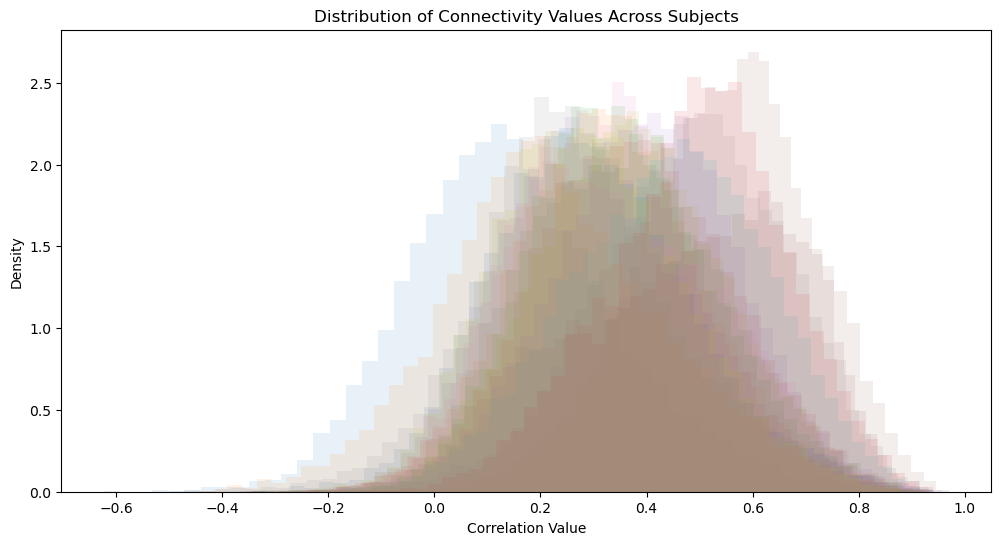

In [18]:
# Plot distribution of connectivity values for each subject
plt.figure(figsize=(12, 6))
for sub in subs:
    matrix = np.load(f'{curr_dir}/results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy')
    plt.hist(matrix[np.tril_indices_from(matrix, k=-1)], 
             bins=50, alpha=0.1, density=True)
plt.title('Distribution of Connectivity Values Across Subjects')
plt.xlabel('Correlation Value')
plt.ylabel('Density')
plt.show()

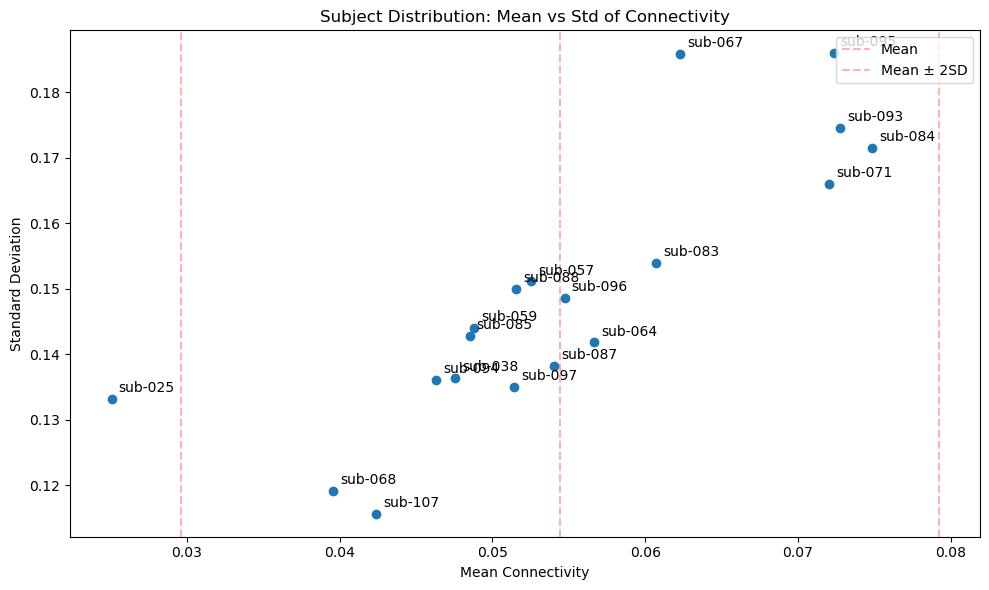

In [15]:
# Create scatter plot of mean vs std for each subject
plt.figure(figsize=(10, 6))

# Calculate means and stds for each subject
means = []
stds = []
for sub in subs:
    matrix = np.load(f'{curr_dir}/results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy')
    # Calculate using lower triangle of matrix (excluding diagonal)
    lower_triangle = matrix[np.tril_indices_from(matrix, k=-1)]
    means.append(np.mean(lower_triangle))
    stds.append(np.std(lower_triangle))

plt.scatter(means, stds)
for i, sub in enumerate(subs):
    plt.annotate(f'{sub}', (means[i], stds[i]), xytext=(5, 5), textcoords='offset points')

plt.xlabel('Mean Connectivity')
plt.ylabel('Standard Deviation')
plt.title('Subject Distribution: Mean vs Std of Connectivity')

# Add reference lines for mean ± 2SD
mean_of_means = np.mean(means)
std_of_means = np.std(means)
plt.axvline(mean_of_means, color='r', linestyle='--', alpha=0.3, label='Mean')
plt.axvline(mean_of_means + 2*std_of_means, color='r', linestyle='--', alpha=0.3, label='Mean ± 2SD')
plt.axvline(mean_of_means - 2*std_of_means, color='r', linestyle='--', alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()

In [2]:
# plot connectome and visuals for group level
import os
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load subject information
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = ['sub-084']
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Set up directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load coordinates
coords_path = 'analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_2mm.csv'
coords_df = pd.read_csv(coords_path)
coords = coords_df[['R', 'A', 'S']].values

def load_all_matrices():
    """Load and average matrices across all subjects"""
    all_matrices = []
    
    for sub in subs:
        matrix_path = f'results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy'
        if os.path.exists(matrix_path):
            try:
                matrix = np.load(matrix_path)
                all_matrices.append(matrix)
                logging.info(f"Loaded matrix for subject {sub}")
            except Exception as e:
                logging.error(f"Error loading matrix for {sub}: {str(e)}")
    
    if not all_matrices:
        raise ValueError("No matrices were successfully loaded")
    
    print("Loaded matrices")
    
    # Calculate mean and standard deviation across subjects
    mean_matrix = np.mean(all_matrices, axis=0)
    std_matrix = np.std(all_matrices, axis=0)
    
    return mean_matrix, std_matrix, len(all_matrices)

def create_group_visualizations(mean_matrix, std_matrix, n_subjects):
    """Create group-level visualizations"""
    # Plot 1: Correlation Matrix
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = plt.subplot(121)
    matrix_plot = mean_matrix.copy()
    np.fill_diagonal(matrix_plot, 0)
    
    plotting.plot_matrix(
        matrix_plot,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        title=f'Group Mean Correlation Matrix (n={n_subjects})',
        axes=ax1
    )
    
    # Plot 2.1: Brain Connectome as separate figure
    fig_connectome = plt.figure(figsize=(8, 6))
    display = plotting.plot_connectome(
        mean_matrix,
        coords,
        edge_threshold="85%",
        node_size=5,
        node_color='auto',
        colorbar=True,
        title=f'Group Mean Brain Connectome 85% (n={n_subjects})',
        display_mode='ortho'
    )
    
    # Plot 2.2: Brain Connectome as separate figure - RAW
    fig_connectome = plt.figure(figsize=(8, 6))
    display = plotting.plot_connectome(
        mean_matrix,
        coords,
        edge_threshold="0%",
        node_size=5,
        node_color='auto',
        colorbar=True,
        title=f'Group Mean Brain Connectome RAW (n={n_subjects})',
        display_mode='ortho'
    )
    
    # Show both plots
    plt.show()
    
    # Create interactive 3D view
    view = plotting.view_connectome(
        mean_matrix,
        coords,
        edge_threshold="0%"
    )
    
    # Print connectivity statistics
    print("\nGroup-Level Connectivity Statistics:")
    print(f"Number of subjects: {n_subjects}")
    print(f"Shape: {mean_matrix.shape}")
    print(f"Value range: [{mean_matrix.min():.3f}, {mean_matrix.max():.3f}]")
    print(f"Number of regions: {len(coords)}")

def main():
    try:
        # Load and average all matrices
        mean_matrix, std_matrix, n_subjects = load_all_matrices()
        
        # Create group-level visualizations
        create_group_visualizations(mean_matrix, std_matrix, n_subjects)
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_2mm.csv'

Original dimensions:
MSDL: (40, 48, 35, 39)
MSDL affine:
[[   4.    0.    0.  -78.]
 [   0.    4.    0. -111.]
 [   0.    0.    4.  -51.]
 [   0.    0.    0.    1.]]
Schaefer: (91, 109, 91)
Schaefer affine:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
Func: (91, 109, 91, 184)
Func affine:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:67: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  "Given img is empty. "
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:439: UserWarning: empty mask
  new_img_like(img, not_mask, affine)
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Region Coverage Statistics:
Mean coverage: 0.999
Min coverage: 0.913
Number of regions with <50% coverage: 0


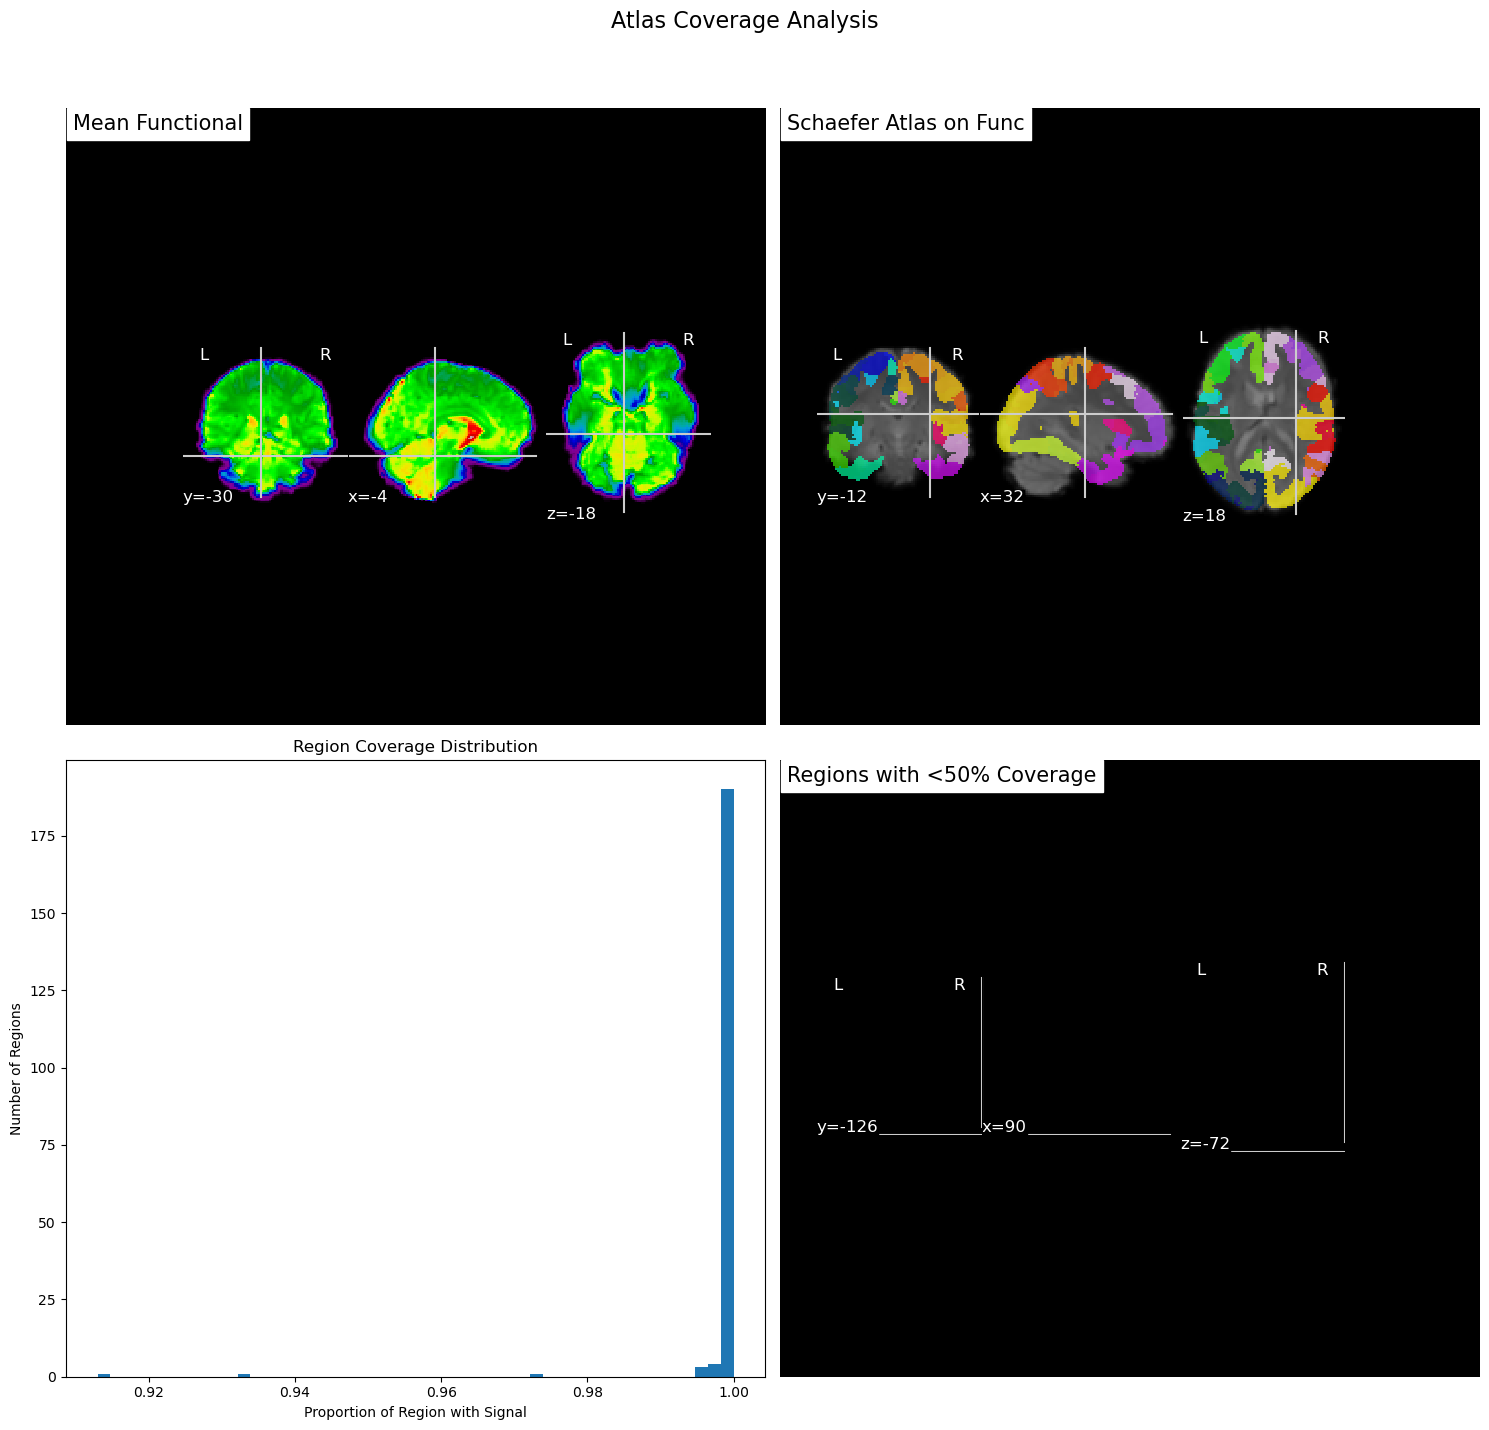

In [ ]:
# plot check
import os
import numpy as np
import nibabel as nib
from nilearn import datasets, plotting, image
import matplotlib.pyplot as plt
import ptoc_params as params

def check_atlases_and_data():
    # Load atlases
    msdl = datasets.fetch_atlas_msdl()
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)  # Changed to 2mm
    
    # Load atlas images
    msdl_img = nib.load(msdl.maps)
    schaefer_img = nib.load(schaefer['maps'])
    
    # Load example functional data
    sub = 'sub-025'
    run = 1
    func_path = f'{params.raw_dir}/{sub}/ses-01/derivatives/reg_standard/filtered_func_run-0{run}_standard.nii.gz'
    func_img = nib.load(func_path)
    mean_func = image.mean_img(func_img)
    
    # Print basic info and shapes
    print("Original dimensions:")
    print(f"MSDL: {msdl_img.shape}")
    print(f"MSDL affine:\n{msdl_img.affine}")
    print(f"Schaefer: {schaefer_img.shape}")
    print(f"Schaefer affine:\n{schaefer_img.affine}")
    print(f"Func: {func_img.shape}")
    print(f"Func affine:\n{func_img.affine}")
    
    # Create visualization figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Atlas Coverage Analysis', fontsize=16)
    
    # Plot mean functional
    plotting.plot_epi(mean_func, axes=axes[0,0], title='Mean Functional')
    
    # Plot Schaefer atlas
    plotting.plot_roi(schaefer_img, mean_func, axes=axes[0,1], 
                     title='Schaefer Atlas on Func')
    
    # Analyze coverage
    schaefer_data = schaefer_img.get_fdata()
    func_data = mean_func.get_fdata()
    
    region_counts = []
    signal_counts = []
    
    for i in range(1, 201):  # Schaefer has 200 regions
        region_mask = schaefer_data == i
        region_voxels = np.sum(region_mask)
        signal_voxels = np.sum((func_data[region_mask] != 0))
        region_counts.append(region_voxels)
        signal_counts.append(signal_voxels)
    
    coverage = np.array(signal_counts) / np.array(region_counts)
    
    # Plot the coverage distribution
    axes[1,0].hist(coverage, bins=50)
    axes[1,0].set_title('Region Coverage Distribution')
    axes[1,0].set_xlabel('Proportion of Region with Signal')
    axes[1,0].set_ylabel('Number of Regions')
    
    # Plot regions with low coverage
    masked_schaefer = np.zeros_like(schaefer_data)
    for i in range(200):
        if coverage[i] < 0.5:  # Highlight low coverage regions
            masked_schaefer[schaefer_data == (i+1)] = 1
            
    plotting.plot_roi(nib.Nifti1Image(masked_schaefer, schaefer_img.affine),
                     mean_func,
                     axes=axes[1,1],
                     title='Regions with <50% Coverage')
    
    # Print summary stats
    print("\nRegion Coverage Statistics:")
    print(f"Mean coverage: {np.mean(coverage):.3f}")
    print(f"Min coverage: {np.min(coverage):.3f}")
    print(f"Number of regions with <50% coverage: {np.sum(coverage < 0.5)}")
    
    # List problematic regions
    low_coverage_idx = np.where(coverage < 0.5)[0]
    if len(low_coverage_idx) > 0:
        print("\nRegions with <50% coverage:")
        for idx in low_coverage_idx:
            print(f"Region {idx+1}: {coverage[idx]:.3f} coverage")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save results
    curr_dir = '/user_data/csimmon2/git_repos/ptoc'
    results_dir = f'{curr_dir}/results/atlas_diagnostics'
    os.makedirs(results_dir, exist_ok=True)
    plt.savefig(f'{results_dir}/atlas_coverage_analysis.png')
    
    return coverage

if __name__ == "__main__":
    coverage = check_atlases_and_data()

In [42]:
# Plot GSC

# Get the atlas and coordinates
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
coords = plotting.find_parcellation_cut_coords(atlas.maps)

# Get list of all precision matrix files
precision_files = [f for f in os.listdir(f'{results_dir}/group_sparse_covariance') if 'precision.npy' in f]

# Load and average all precision matrices
precision_matrices = []
for file in precision_files:
    precision_matrix = np.load(f'{results_dir}/group_sparse_covariance/{file}')
    precision_matrices.append(precision_matrix)

# Calculate mean precision matrix
group_precision = np.mean(precision_matrices, axis=0)

# Create group-level brain connectivity plot
plotting.plot_connectome(
    -group_precision,
    coords,
    edge_threshold='90%',
    title='Group Average Brain Connectivity (GSC)',
    display_mode='lzr',
    edge_vmax=0.5,
    edge_vmin=-0.5,
    node_color='auto'
)
plotting.show()

FileNotFoundError: [Errno 2] No such file or directory: '/user_data/csimmon2/git_repos/ptoc/results/group_sparse_covariance'

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import GroupSparseCovarianceCV
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Paths and parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

def plot_matrices(cov, prec, title):
    """Plot covariance and precision matrices."""
    prec = prec.copy()  # avoid side effects
    
    # Put zeros on the diagonal, for graph clarity
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))
    
    # Display covariance matrix
    plotting.plot_matrix(
        cov,
        cmap=plotting.cm.bwr,
        vmin=-1,
        vmax=1,
        title=f"{title} / covariance",
        #labels=labels, # will need to verify - from example
    )
    # Display precision matrix
    plotting.plot_matrix(
        prec,
        cmap=plotting.cm.bwr,
        vmin=-span,
        vmax=span,
        title=f"{title} / precision",
        #labels=labels, # will need to verify - from example
    )

def get_subject_data(subject):
    """Get all runs for a subject and concatenate them."""
    runs = list(range(1, 4))  # runs 1-3
    all_run_data = []
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    
    # Simplified masker
    masker = NiftiLabelsMasker(
        labels_img=atlas.maps,
        standardize=True,
        memory='nilearn_cache',
        verbose=0
    )
    
    for run in runs:
        run_path = f'{raw_dir}/{subject}/ses-01/derivatives/reg_standard/filtered_func_run-0{run}_standard.nii.gz'
        
        if not os.path.exists(run_path):
            logging.warning(f'Run data not found: {run_path}')
            continue
            
        # Load and verify data
        img = nib.load(run_path)
        if img.shape[:3] != (91, 109, 91):
            logging.warning(f"Unexpected shape for {subject} run-{run}: {img.shape}")
            continue
            
        # Extract time series
        time_series = masker.fit_transform(img)
        all_run_data.append(time_series)
    
    if not all_run_data:
        return None
        
    # Concatenate all runs
    return np.concatenate(all_run_data, axis=0)

def main():
    # Collect data from all subjects
    subject_time_series = []
    valid_subjects = []
    
    for subject in subs:
        logging.info(f"Processing subject: {subject}")
        time_series = get_subject_data(subject)
        
        if time_series is not None:
            subject_time_series.append(time_series)
            valid_subjects.append(subject)
    
    if not subject_time_series:
        logging.error("No valid subject data found")
        return
    
    # Convert to numpy array with specific dtype
    subject_time_series = np.array(subject_time_series, dtype=np.float64)
        
    # Compute Group Sparse Covariance with modified parameters
    logging.info("Computing Group Sparse Covariance...")
    gsc = GroupSparseCovarianceCV(
        verbose=1,
        max_iter=50,  # Default is 10
        tol=1e-3,     # Default is 1e-3, could try 1e-2 for less strict convergence
        n_jobs=1
    )
    gsc.fit(subject_time_series)
    
    # Save results
    output_dir = f'{results_dir}/group_sparse_covariance'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save a matrix for each subject
    for idx, subject in enumerate(valid_subjects):
        np.save(f'{output_dir}/{subject}_covariance.npy', gsc.covariances_[..., idx])
        np.save(f'{output_dir}/{subject}_precision.npy', gsc.precisions_[..., idx])
    
    # Generate plots for each subject
    for idx, subject in enumerate(valid_subjects):
        plot_matrices(
            gsc.covariances_[..., idx],
            gsc.precisions_[..., idx],
            f"GroupSparseCovariance - Subject {subject}"
        )
    
    plotting.show()
    
    logging.info("Analysis complete!")

if __name__ == "__main__":
    main()

2024-11-15 18:12:45,677 - INFO - Processing subject: sub-025


2024-11-15 18:12:59,436 - INFO - Processing subject: sub-038
2024-11-15 18:13:13,216 - INFO - Processing subject: sub-057
2024-11-15 18:13:27,097 - INFO - Processing subject: sub-059
2024-11-15 18:13:40,823 - INFO - Processing subject: sub-064
2024-11-15 18:13:54,561 - INFO - Processing subject: sub-067
2024-11-15 18:14:08,175 - INFO - Processing subject: sub-068
2024-11-15 18:14:21,737 - INFO - Processing subject: sub-071
2024-11-15 18:14:35,019 - INFO - Processing subject: sub-083
2024-11-15 18:14:48,897 - INFO - Processing subject: sub-084
2024-11-15 18:15:02,595 - INFO - Processing subject: sub-085
2024-11-15 18:15:16,313 - INFO - Processing subject: sub-087
2024-11-15 18:15:30,290 - INFO - Processing subject: sub-088
2024-11-15 18:15:44,072 - INFO - Processing subject: sub-093
2024-11-15 18:15:57,910 - INFO - Processing subject: sub-094
2024-11-15 18:16:11,615 - INFO - Processing subject: sub-095
2024-11-15 18:16:25,391 - INFO - Processing subject: sub-096
2024-11-15 18:16:39,275 

UnboundLocalError: local variable 'best_index' referenced before assignment

In [41]:
# Group Sparse Covariance Analysis with Schaefer Atlas

import os
import sys
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import GroupSparseCovarianceCV
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Paths and parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

def get_subject_data(subject):
    """Get all runs for a subject and concatenate them."""
    runs = list(range(1, 4))  # runs 1-3
    all_run_data = []
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    
    # Simplified masker
    masker = NiftiLabelsMasker(
        labels_img=atlas.maps,
        standardize=True,
        memory='nilearn_cache',
        verbose=0
    )
    
    for run in runs:
        run_path = f'{raw_dir}/{subject}/ses-01/derivatives/reg_standard/filtered_func_run-0{run}_standard.nii.gz'
        
        if not os.path.exists(run_path):
            logging.warning(f'Run data not found: {run_path}')
            continue
            
        # Load and verify data
        img = nib.load(run_path)
        if img.shape[:3] != (91, 109, 91):
            logging.warning(f"Unexpected shape for {subject} run-{run}: {img.shape}")
            continue
            
        # Extract time series
        time_series = masker.fit_transform(img)
        all_run_data.append(time_series)
    
    if not all_run_data:
        return None
        
    # Concatenate all runs
    return np.concatenate(all_run_data, axis=0)

def main():
    # Collect data from all subjects
    subject_time_series = []
    valid_subjects = []
    
    for subject in subs:
        logging.info(f"Processing subject: {subject}")
        time_series = get_subject_data(subject)
        
        if time_series is not None:
            # Compute empirical covariance first
            emp_cov = np.dot(time_series.T, time_series) / time_series.shape[0]
            # Check if covariance is well-conditioned
            eigvals = np.linalg.eigvals(emp_cov)
            condition_number = np.max(np.abs(eigvals)) / np.min(np.abs(eigvals))
            logging.info(f"Condition number for {subject}: {condition_number}")
            
            subject_time_series.append(time_series)
            valid_subjects.append(subject)
    
    if not subject_time_series:
        logging.error("No valid subject data found")
        return
    
    # Convert to numpy array
    subject_time_series = np.array(subject_time_series)
    
    # Compute Group Sparse Covariance with more controlled parameters
    logging.info("Computing Group Sparse Covariance...")
    gsc = GroupSparseCovarianceCV(
        alphas=5,          # Use 5 alphas for CV
        max_iter=100,      # Increase max iterations
        tol=1e-4,         # Slightly looser tolerance
        verbose=1,
        n_jobs=1,
        n_refinements=2    # Reduce number of refinements
    )
    
    try:
        gsc.fit(subject_time_series)
        
        # Save results
        output_dir = f'{results_dir}/group_sparse_covariance'
        os.makedirs(output_dir, exist_ok=True)
        
        # Save a matrix for each subject
        for idx, subject in enumerate(valid_subjects):
            np.save(f'{output_dir}/{subject}_covariance.npy', gsc.covariances_[..., idx])
            np.save(f'{output_dir}/{subject}_precision.npy', gsc.precisions_[..., idx])
        
        logging.info("Analysis complete!")
        
    except Exception as e:
        logging.error(f"Error in GroupSparseCovarianceCV: {e}")
        return

if __name__ == "__main__":
    main()

2024-11-16 00:03:21,301 - INFO - Processing subject: sub-025


2024-11-16 00:03:34,940 - INFO - Condition number for sub-025: 5526.61181640625
2024-11-16 00:03:34,941 - INFO - Processing subject: sub-038
2024-11-16 00:03:48,642 - INFO - Condition number for sub-038: 10960.5439453125
2024-11-16 00:03:48,644 - INFO - Processing subject: sub-057
2024-11-16 00:04:02,130 - INFO - Condition number for sub-057: 15750.7958984375
2024-11-16 00:04:02,131 - INFO - Processing subject: sub-059
2024-11-16 00:04:15,685 - INFO - Condition number for sub-059: 14160.8701171875
2024-11-16 00:04:15,686 - INFO - Processing subject: sub-064
2024-11-16 00:04:29,579 - INFO - Condition number for sub-064: 13354.9326171875
2024-11-16 00:04:29,581 - INFO - Processing subject: sub-067
2024-11-16 00:04:43,567 - INFO - Condition number for sub-067: 44250.34375
2024-11-16 00:04:43,569 - INFO - Processing subject: sub-068
2024-11-16 00:04:57,709 - INFO - Condition number for sub-068: 12810.84375
2024-11-16 00:04:57,710 - INFO - Processing subject: sub-071
2024-11-16 00:05:12,023